# Building an RNN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/noelkonagai/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
        
    def next_batch(self, batch_size, steps, return_batch_ts = False):
        
        # this gets a random starting point for the next batch
        rand_start = np.random.rand(batch_size, 1)
        
        # converts the value to be on the time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        # creates a batch of time series on the time axis
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
        
        # creates a y data for the time series in the batches
        y_batch = np.sin(batch_ts)
        
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1), batch_ts
        else: 
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1)

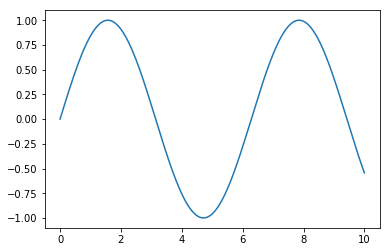

In [3]:
ts_data = TimeSeriesData(250, 0, 10)
plt.plot(ts_data.x_data, ts_data.y_true)

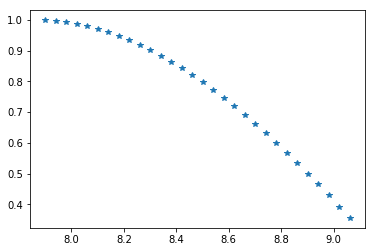

In [4]:
num_time_steps = 30
y1, y2, ts = ts_data.next_batch(1, num_time_steps, return_batch_ts=True)
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

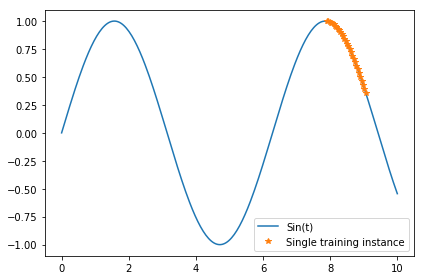

In [5]:
plt.plot(ts_data.x_data, ts_data.y_true, label = 'Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label = 'Single training instance')
plt.legend()
plt.tight_layout()

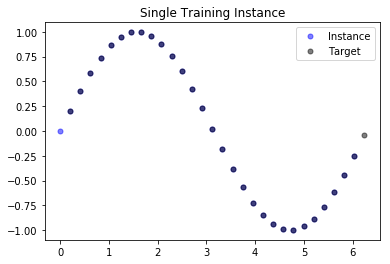

In [6]:
train_inst = np.linspace(0, 5 + ts_data.resolution * (num_time_steps + 1), num_time_steps + 1)

plt.title("Single Training Instance")
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize = 5, alpha= 0.5, label = 'Instance')
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), 'ko', markersize = 5, alpha= 0.5, label = 'Target')
plt.legend()

# RNN Model

In [7]:
tf.reset_default_graph()

num_inputs = 1
num_neurons = 200
num_outputs = 1
learning_rate = 0.0001
num_train_iter = 2000
batch_size = 1

## Placeholders

In [8]:
X = tf.placeholder(tf.float32, shape = [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, shape = [None, num_time_steps, num_outputs])

## RNN Cells

In [9]:
cell = tf.contrib.rnn.GRUCell(num_units = num_neurons, activation=tf.nn.relu)
wrapped_cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size = num_outputs)

In [10]:
output, states = tf.nn.dynamic_rnn(wrapped_cell, X, dtype = tf.float32)
loss = tf.reduce_mean(tf.square(output - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.85)
saver = tf.train.Saver()

In [11]:
with tf.Session(config = tf.ConfigProto(gpu_options = gpu_options)) as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iter):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict = {X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict = {X: X_batch, y: y_batch})
            print(iteration, "\tMSE ", mse)
    
    saver.save(sess, "./rnn_time_codealong")
    

0 	MSE  0.125588
100 	MSE  0.272647
200 	MSE  0.0685495
300 	MSE  0.0955994
400 	MSE  0.0361852
500 	MSE  0.0487395
600 	MSE  0.0579761
700 	MSE  0.0336819
800 	MSE  0.00208795
900 	MSE  0.00177437
1000 	MSE  0.0159377
1100 	MSE  0.0160845
1200 	MSE  0.0372854
1300 	MSE  0.0350789
1400 	MSE  0.0196098
1500 	MSE  0.00506304
1600 	MSE  0.00398361
1700 	MSE  0.0360009
1800 	MSE  0.0218683
1900 	MSE  0.000702395


INFO:tensorflow:Restoring parameters from ./rnn_time_codealong


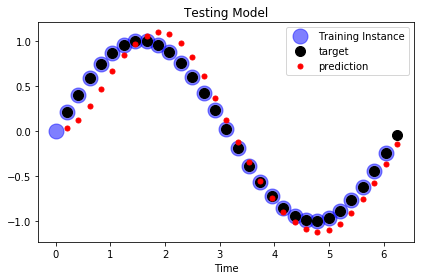

In [12]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_codealong")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(output, feed_dict = {X: X_new})
    
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating a New Sequence

In [13]:
with tf.Session() as sess:
    
    saver.restore(sess, "./rnn_time_codealong")
    
    # seed zeros
    
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        
        y_pred = sess.run(output, feed_dict = {X: X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_codealong


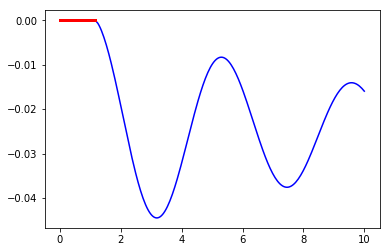

In [14]:
plt.plot(ts_data.x_data, zero_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], 'r', linewidth = 3)

In [15]:
with tf.Session() as sess:
    
    saver.restore(sess, "./rnn_time_codealong")
    
    # seed zeros
    
    training_instance = list(ts_data.y_true[:30])
    
    for iteration in range(len(training_instance) - num_time_steps):
        
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        
        y_pred = sess.run(output, feed_dict = {X: X_batch})
        
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_codealong


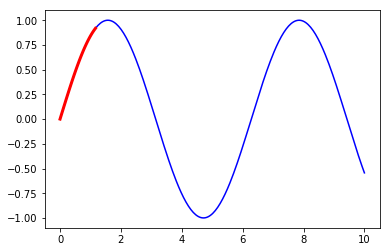

In [16]:
plt.plot(ts_data.x_data, ts_data.y_true, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], 'r', linewidth = 3)